<a href="https://colab.research.google.com/github/shubhamt2897/DL_BB/blob/main/DL_Bounding_Box.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Installing Dependencies

In [1]:
!pip install --upgrade torch torchvision
!pip install numpy matplotlib albumentations kornia open3d gdown



  Using cached kornia-0.8.0-py2.py3-none-any.whl.metadata (17 kB)
  Using cached open3d-0.19.0-cp311-cp311-manylinux_2_31_x86_64.whl.metadata (4.3 kB)
  Using cached kornia_rs-0.1.8-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (10 kB)
  Using cached dash-2.18.2-py3-none-any.whl.metadata (10 kB)
  Using cached ConfigArgParse-1.7-py3-none-any.whl.metadata (23 kB)
  Using cached ipywidgets-8.1.5-py3-none-any.whl.metadata (2.3 kB)
  Using cached addict-2.4.0-py3-none-any.whl.metadata (1.0 kB)
  Using cached pyquaternion-0.9.9-py3-none-any.whl.metadata (1.4 kB)
  Using cached flask-3.0.3-py3-none-any.whl.metadata (3.2 kB)
  Using cached werkzeug-3.0.6-py3-none-any.whl.metadata (3.7 kB)
  Using cached dash_html_components-2.0.0-py3-none-any.whl.metadata (3.8 kB)
  Using cached dash_core_components-2.0.0-py3-none-any.whl.metadata (2.9 kB)
  Using cached dash_table-5.0.0-py3-none-any.whl.metadata (2.4 kB)
  Using cached retrying-1.3.4-py3-none-any.whl.metadata (6.9 kB)
 

In [ ]:
!nvidia-smi


Download & Extract Your Dataset

In [2]:
# Download from Google Drive using gdown
!gdown "https://drive.google.com/uc?id=11s-GLb6LZ0SCAVW6aikqImuuQEEbT_Fb" -O dl_challenge.tar.xz

# Extract the .tar.xz file
!tar -xvf dl_challenge.tar.xz  # This should create a dl_challenge/ directory


Downloading...
From (original): https://drive.google.com/uc?id=11s-GLb6LZ0SCAVW6aikqImuuQEEbT_Fb
From (redirected): https://drive.google.com/uc?id=11s-GLb6LZ0SCAVW6aikqImuuQEEbT_Fb&confirm=t&uuid=7b97dfb1-a330-44d3-a4ad-72cac7902bea
To: /content/dl_challenge.tar.xz
100% 2.44G/2.44G [00:20<00:00, 117MB/s] 
dl_challenge/
dl_challenge/889a9fb3-9915-11ee-9103-bbb8eae05561/
dl_challenge/889a9fb3-9915-11ee-9103-bbb8eae05561/rgb.jpg
dl_challenge/889a9fb3-9915-11ee-9103-bbb8eae05561/pc.npy
dl_challenge/889a9fb3-9915-11ee-9103-bbb8eae05561/bbox3d.npy
dl_challenge/889a9fb3-9915-11ee-9103-bbb8eae05561/mask.npy
dl_challenge/911224fa-9915-11ee-9103-bbb8eae05561/
dl_challenge/911224fa-9915-11ee-9103-bbb8eae05561/rgb.jpg
dl_challenge/911224fa-9915-11ee-9103-bbb8eae05561/pc.npy
dl_challenge/911224fa-9915-11ee-9103-bbb8eae05561/bbox3d.npy
dl_challenge/911224fa-9915-11ee-9103-bbb8eae05561/mask.npy
dl_challenge/9f50f3c2-9915-11ee-9103-bbb8eae05561/
dl_challenge/9f50f3c2-9915-11ee-9103-bbb8eae05561/rgb.jp

In [3]:
import os
import glob

data_dir = 'dl_challenge'  # or the path where dl_challenge is located
folders = sorted(glob.glob(os.path.join(data_dir, '*')))
print("Number of data folders:", len(folders))
print("First folder name:", folders[0])
print("Files in the first folder:", os.listdir(folders[0]))



Number of data folders: 200
First folder name: dl_challenge/859074c2-9915-11ee-9103-bbb8eae05561
Files in the first folder: ['mask.npy', 'pc.npy', 'rgb.jpg', 'bbox3d.npy']


**Dataset & Preprocessing**

In [4]:
import os

folder_path = 'dl_challenge/96e66c6d-9915-11ee-9103-bbb8eae05561'
print("Files in the folder:", os.listdir(folder_path))


Files in the folder: ['mask.npy', 'pc.npy', 'rgb.jpg', 'bbox3d.npy']


**Data Loading, Model Definition & Training Setup**

 Create a PyTorch Dataset Class

In [5]:
import torch
from torch.utils.data import Dataset
import albumentations as A
import cv2
import numpy as np
import os

class Sereact3DDataset(Dataset):
    def __init__(self, folder_list, transform=None):
        self.folder_list = folder_list
        self.transform = transform

        # Filter folders to include only those with all required files.
        self.folder_list = [
            folder for folder in self.folder_list
            if all(os.path.isfile(os.path.join(folder, fname))
                   for fname in ['rgb.jpg', 'bbox3d.npy', 'mask.npy', 'pc.npy'])
        ]

    def __len__(self):
        return len(self.folder_list)

    def __getitem__(self, idx):
        folder_path = self.folder_list[idx]
        rgb_path   = os.path.join(folder_path, 'rgb.jpg')
        bbox_path  = os.path.join(folder_path, 'bbox3d.npy')
        mask_path  = os.path.join(folder_path, 'mask.npy')
        pc_path    = os.path.join(folder_path, 'pc.npy')

        # Load files
        rgb = cv2.imread(rgb_path)[:, :, ::-1]  # Convert BGR to RGB
        bbox3d = np.load(bbox_path)
        mask = np.load(mask_path)
        point_cloud = np.load(pc_path)

        # If point_cloud is image-like (shape: [3, H, W]), convert it.
        if point_cloud.ndim == 3 and point_cloud.shape[0] == 3:
            point_cloud = np.transpose(point_cloud, (1, 2, 0))
            point_cloud = point_cloud.reshape(-1, 3)

        # Apply transform to RGB if provided.
        if self.transform:
            augmented = self.transform(image=rgb)
            rgb = augmented['image']

        # Convert to torch tensors
        rgb = torch.from_numpy(rgb).permute(2, 0, 1).float()  # (C, H, W)
        bbox3d = torch.from_numpy(bbox3d).float()
        mask = torch.from_numpy(mask).float()
        point_cloud = torch.from_numpy(point_cloud).float()  # Expected: [N, 3]

        return {
            'rgb': rgb,
            'bbox3d': bbox3d,
            'mask': mask,
            'point_cloud': point_cloud
        }


**Define Transforms and Create DataLoaders**

In [6]:
import glob
from torch.utils.data import DataLoader
import albumentations as A

train_transform = A.Compose([
    A.Resize(224, 224),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
])
val_transform = A.Compose([A.Resize(224, 224)])

data_dir = 'dl_challenge'
folders = sorted(glob.glob(os.path.join(data_dir, '*')))

train_folders = folders[:150]
val_folders = folders[150:180]
test_folders = folders[180:]

train_dataset = Sereact3DDataset(train_folders, transform=train_transform)
val_dataset   = Sereact3DDataset(val_folders, transform=val_transform)
test_dataset  = Sereact3DDataset(test_folders, transform=val_transform)

import torch

def convert_bbox_corners_to_params(corners):
    """
    Converts bounding box corners (tensor of shape [8, 3]) to a 7-parameter vector.
    For demonstration purposes:
      - Center is computed as the mean of the corners.
      - Dimensions are computed as the difference between the max and min along each axis.
      - Heading is set to 0.
    Returns a tensor of shape [7].
    """
    center = corners.mean(dim=0)  # [3]
    dims = corners.max(dim=0)[0] - corners.min(dim=0)[0]  # [3]
    heading = torch.tensor([0.0], device=corners.device)  # [1]
    return torch.cat([center, dims, heading], dim=0)  # [7]

def custom_collate(batch):
    collated = {}
    for key in batch[0]:
        if key == 'bbox3d':
            # For each sample, take the first bounding box and convert its corners to a 7-parameter vector.
            collated[key] = torch.stack([convert_bbox_corners_to_params(item[key][0]) for item in batch])
        else:
            try:
                collated[key] = torch.stack([item[key] for item in batch])
            except RuntimeError:
                collated[key] = [item[key] for item in batch]
    return collated



train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=custom_collate)
val_loader   = DataLoader(val_dataset, batch_size=4, shuffle=False, collate_fn=custom_collate)
test_loader  = DataLoader(test_dataset, batch_size=4, shuffle=False, collate_fn=custom_collate)


 Define the Model

In [7]:
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

class Simple3DBBoxModel(nn.Module):
    def __init__(self):
        super(Simple3DBBoxModel, self).__init__()
        resnet = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
        self.rgb_backbone = nn.Sequential(*list(resnet.children())[:-1])  # [B, 512, 1, 1]

        self.pc_branch = nn.Sequential(
            nn.Linear(3, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
        )

        # 512 from ResNet + 256 from PC branch -> 256 -> 7
        self.fc = nn.Sequential(
            nn.Linear(512 + 256, 256),
            nn.ReLU(),
            nn.Linear(256, 7)
        )

    def forward(self, rgb, point_cloud):
        # rgb shape: [B, 3, 224, 224]
        x_rgb = self.rgb_backbone(rgb)         # [B, 512, 1, 1]
        x_rgb = x_rgb.view(x_rgb.size(0), -1)  # [B, 512]

        # point_cloud might be a list if shapes vary
        if isinstance(point_cloud, list):
            pc_feats_list = []
            device_here = x_rgb.device
            for pc in point_cloud:
                pc = pc.to(device_here)
                # pc shape could be [N, 3]
                if pc.dim() == 3:
                    # might be [B*, N, 3] => handle carefully
                    pc = pc.squeeze(0)  # if there's an extra dimension
                N, C = pc.shape
                feats = self.pc_branch(pc)
                feats = feats.mean(dim=0)  # [256]
                pc_feats_list.append(feats)
            pc_feats = torch.stack(pc_feats_list, dim=0)  # [B, 256]
        else:
            # point_cloud shape: [B, N, 3]
            B, N, C = point_cloud.shape
            point_cloud = point_cloud.to(x_rgb.device)
            pc_flat = point_cloud.view(B * N, C)  # [B*N, 3]
            feats = self.pc_branch(pc_flat)       # [B*N, 256]
            pc_feats = feats.view(B, N, -1).mean(dim=1)  # [B, 256]

        # fuse
        fused = torch.cat([x_rgb, pc_feats], dim=1)  # [B, 768]
        out = self.fc(fused)  # [B, 7]
        return out


Define Loss & Training Routine

In [8]:
import torch.optim as optim

def bbox3d_loss(pred, target):
    # We'll do a Smooth L1 regression on the 7 parameters
    return F.smooth_l1_loss(pred, target)

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, device='cuda'):
    model.to(device)
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0.0
        for batch in train_loader:
            rgb = batch['rgb'].to(device)
            pc  = batch['point_cloud']
            gt_bbox = batch['bbox3d'].to(device)

            optimizer.zero_grad()
            pred_bbox = model(rgb, pc)
            loss = criterion(pred_bbox, gt_bbox)
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validation
        model.eval()
        total_val_loss = 0.0
        with torch.no_grad():
            for batch in val_loader:
                rgb = batch['rgb'].to(device)
                pc  = batch['point_cloud']
                gt_bbox = batch['bbox3d'].to(device)

                pred_bbox = model(rgb, pc)
                val_loss = criterion(pred_bbox, gt_bbox)
                total_val_loss += val_loss.item()

        avg_val_loss = total_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        print(f"Epoch [{epoch+1}/{num_epochs}] | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

    return train_losses, val_losses


Launch Training

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

model = Simple3DBBoxModel()
model.to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = bbox3d_loss

train_losses, val_losses = train_model(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    num_epochs=10,
    device=device
)


Using device: cuda
Epoch [1/10] | Train Loss: 0.0152 | Val Loss: 0.0090
Epoch [2/10] | Train Loss: 0.0045 | Val Loss: 0.0055
Epoch [3/10] | Train Loss: 0.0029 | Val Loss: 0.0042
Epoch [4/10] | Train Loss: 0.0023 | Val Loss: 0.0041
Epoch [5/10] | Train Loss: 0.0019 | Val Loss: 0.0032
Epoch [6/10] | Train Loss: 0.0016 | Val Loss: 0.0035
Epoch [7/10] | Train Loss: 0.0017 | Val Loss: 0.0031
Epoch [8/10] | Train Loss: 0.0014 | Val Loss: 0.0028
Epoch [9/10] | Train Loss: 0.0014 | Val Loss: 0.0030
Epoch [10/10] | Train Loss: 0.0013 | Val Loss: 0.0028


**Testing and (Optional) 3D IoU Calculation**

In [10]:
import numpy as np
import torch

def iou_3d_axis_aligned(paramsA, paramsB):
    """
    3D IoU for axis-aligned boxes:
      params = [x, y, z, dx, dy, dz, heading]
    heading is ignored here.
    """
    xA, yA, zA, dxA, dyA, dzA, _ = paramsA
    xB, yB, zB, dxB, dyB, dzB, _ = paramsB

    # Box A corners
    minAx = xA - dxA/2
    maxAx = xA + dxA/2
    minAy = yA - dyA/2
    maxAy = yA + dyA/2
    minAz = zA - dzA/2
    maxAz = zA + dzA/2

    # Box B corners
    minBx = xB - dxB/2
    maxBx = xB + dxB/2
    minBy = yB - dyB/2
    maxBy = yB + dyB/2
    minBz = zB - dzB/2
    maxBz = zB + dzB/2

    # Intersection
    interMinX = max(minAx, minBx)
    interMaxX = min(maxAx, maxBx)
    interMinY = max(minAy, minBy)
    interMaxY = min(maxAy, maxBy)
    interMinZ = max(minAz, minBz)
    interMaxZ = min(maxAz, maxBz)

    interDx = max(0.0, interMaxX - interMinX)
    interDy = max(0.0, interMaxY - interMinY)
    interDz = max(0.0, interMaxZ - interMinZ)
    interVol = interDx * interDy * interDz

    volA = dxA * dyA * dzA
    volB = dxB * dyB * dzB
    unionVol = volA + volB - interVol

    if unionVol <= 0:
        return 0.0
    return interVol / unionVol

def compute_3d_iou(pred_params, gt_params):
    return iou_3d_axis_aligned(pred_params, gt_params)

# Evaluate on the test set
device_for_testing = "cpu"  # or "cuda" if you want speed
model.eval().to(device_for_testing)

test_ious = []
with torch.no_grad():
    for batch in test_loader:
        # Move data to device_for_testing
        rgb = batch['rgb'].to(device_for_testing)
        pc  = batch['point_cloud']
        gt_bbox = batch['bbox3d'].to(device_for_testing)

        # Get predictions
        pred_bbox = model(rgb, pc)  # shape [B, 7]

        # For each sample in the batch
        for i in range(pred_bbox.size(0)):
            pred = pred_bbox[i].cpu().numpy()
            gt   = gt_bbox[i].cpu().numpy()
            iou  = compute_3d_iou(pred, gt)
            test_ious.append(iou)

avg_test_iou = sum(test_ious) / len(test_ious) if test_ious else 0
print(f"Average Test IoU (axis-aligned, ignoring heading): {avg_test_iou:.4f}")


Average Test IoU (axis-aligned, ignoring heading): 0.0997


Cell 10: Inference and Visualization

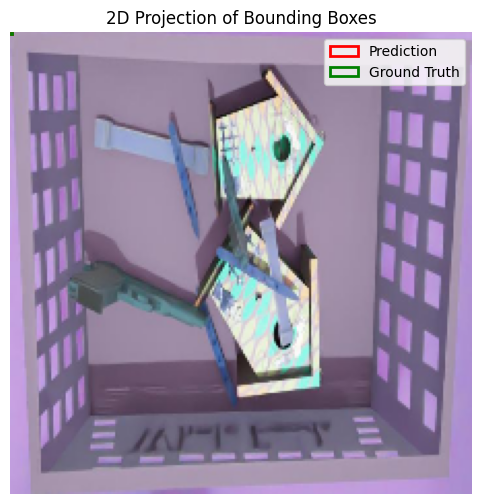

In [11]:
import matplotlib.pyplot as plt

def project_box_2d(bbox):
    """
    Projects a 7-parameter box to a 2D rectangle (xmin, ymin, xmax, ymax)
    using x, y, dx, dy (ignores z and heading).
    """
    x, y, z, dx, dy, dz, heading = bbox
    xmin = x - dx/2
    xmax = x + dx/2
    ymin = y - dy/2
    ymax = y + dy/2
    return xmin, ymin, xmax, ymax

def visualize_2d_bbox(folder_path, pred_bbox, gt_bbox):
    rgb = cv2.imread(os.path.join(folder_path, 'rgb.jpg'))[:, :, ::-1]
    transform = A.Compose([A.Resize(224, 224)])
    rgb_aug = transform(image=rgb)['image']

    pred_box = project_box_2d(pred_bbox)
    gt_box = project_box_2d(gt_bbox)

    fig, ax = plt.subplots(1, 1, figsize=(6,6))
    ax.imshow(rgb_aug)
    rect_pred = plt.Rectangle((pred_box[0], pred_box[1]), pred_box[2]-pred_box[0],
                              pred_box[3]-pred_box[1], fill=False, edgecolor='red', linewidth=2, label='Prediction')
    ax.add_patch(rect_pred)
    rect_gt = plt.Rectangle((gt_box[0], gt_box[1]), gt_box[2]-gt_box[0],
                              gt_box[3]-gt_box[1], fill=False, edgecolor='green', linewidth=2, label='Ground Truth')
    ax.add_patch(rect_gt)
    ax.legend()
    ax.set_title("2D Projection of Bounding Boxes")
    plt.axis("off")
    plt.show()

# Example usage:
example_folder = folders[0]
# Use predicted and GT values from inference; for demonstration:
pred_bbox_example = np.array([0.07, 0.09, 1.02, 0.38, 0.38, 0.21, 0.015])
gt_bbox_example   = np.array([0.10, 0.10, 1.00, 0.40, 0.40, 0.20, 0.0])
visualize_2d_bbox(example_folder, pred_bbox_example, gt_bbox_example)



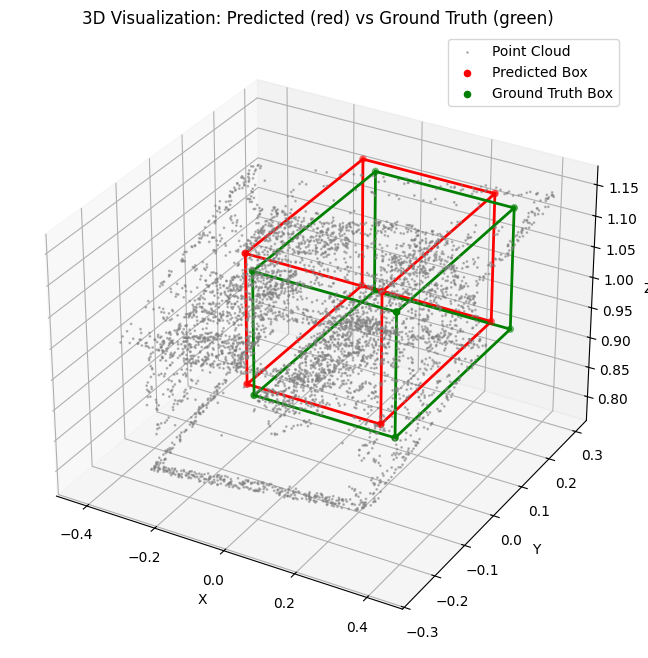

In [12]:
from mpl_toolkits.mplot3d import Axes3D

def box_corners_3d(bbox):
    """
    Converts a 7-parameter box to its 8 corners (axis-aligned, ignoring heading).
    """
    x, y, z, dx, dy, dz, heading = bbox
    min_x, max_x = x - dx/2, x + dx/2
    min_y, max_y = y - dy/2, y + dy/2
    min_z, max_z = z - dz/2, z + dz/2
    corners = np.array([
        [min_x, min_y, min_z],
        [min_x, min_y, max_z],
        [min_x, max_y, min_z],
        [min_x, max_y, max_z],
        [max_x, min_y, min_z],
        [max_x, min_y, max_z],
        [max_x, max_y, min_z],
        [max_x, max_y, max_z]
    ])
    return corners

def visualize_3d_bbox_and_pc(folder_path, pred_bbox, gt_bbox):
    pc = np.load(os.path.join(folder_path, 'pc.npy'))
    if pc.ndim == 3 and pc.shape[0] == 3:
        pc = np.transpose(pc, (1,2,0)).reshape(-1, 3)
    # Sample point cloud for visualization if too many points
    if pc.shape[0] > 5000:
        idx = np.random.choice(pc.shape[0], 5000, replace=False)
        pc = pc[idx, :]

    pred_corners = box_corners_3d(pred_bbox)
    gt_corners   = box_corners_3d(gt_bbox)

    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(pc[:,0], pc[:,1], pc[:,2], s=1, c='gray', alpha=0.5, label='Point Cloud')
    ax.scatter(pred_corners[:,0], pred_corners[:,1], pred_corners[:,2], c='red', label='Predicted Box')
    ax.scatter(gt_corners[:,0], gt_corners[:,1], gt_corners[:,2], c='green', label='Ground Truth Box')

    def draw_box(ax, corners, color):
        edges = [
            [0,1], [0,2], [0,4],
            [1,3], [1,5],
            [2,3], [2,6],
            [3,7],
            [4,5], [4,6],
            [5,7],
            [6,7]
        ]
        for edge in edges:
            pts = corners[edge, :]
            ax.plot(pts[:,0], pts[:,1], pts[:,2], c=color, linewidth=2)

    draw_box(ax, pred_corners, 'red')
    draw_box(ax, gt_corners, 'green')

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.legend()
    plt.title("3D Visualization: Predicted (red) vs Ground Truth (green)")
    plt.show()

# Example usage:
visualize_3d_bbox_and_pc(example_folder, pred_bbox_example, gt_bbox_example)


In [15]:
# Make sure your model is already on the correct device:
model.to(device)
model.eval()

def compute_center_error(pred_bbox, gt_bbox):
    return np.abs(pred_bbox[:3] - gt_bbox[:3]).mean()

def compute_size_error(pred_bbox, gt_bbox):
    return np.abs(pred_bbox[3:6] - gt_bbox[3:6]).mean()

center_errors = []
size_errors = []

with torch.no_grad():
    for batch in test_loader:
        # Move rgb and gt_bbox to device
        rgb = batch['rgb'].to(device)
        gt_bbox = batch['bbox3d'].to(device)

        # If point_cloud is a list, the model's forward will handle it.
        # If it's already a stacked tensor, move it to device.
        pc = batch['point_cloud']
        if not isinstance(pc, list):
            pc = pc.to(device)

        # Forward pass
        pred_bbox = model(rgb, pc)

        # Compute center/size error
        for i in range(pred_bbox.size(0)):
            pred = pred_bbox[i].cpu().numpy()
            gt = gt_bbox[i].cpu().numpy()
            center_errors.append(compute_center_error(pred, gt))
            size_errors.append(compute_size_error(pred, gt))

mean_center_error = np.mean(center_errors)
mean_size_error = np.mean(size_errors)

print("Mean Center L1 Error:", mean_center_error)
print("Mean Size L1 Error:", mean_size_error)


Mean Center L1 Error: 0.06735052
Mean Size L1 Error: 0.043528862


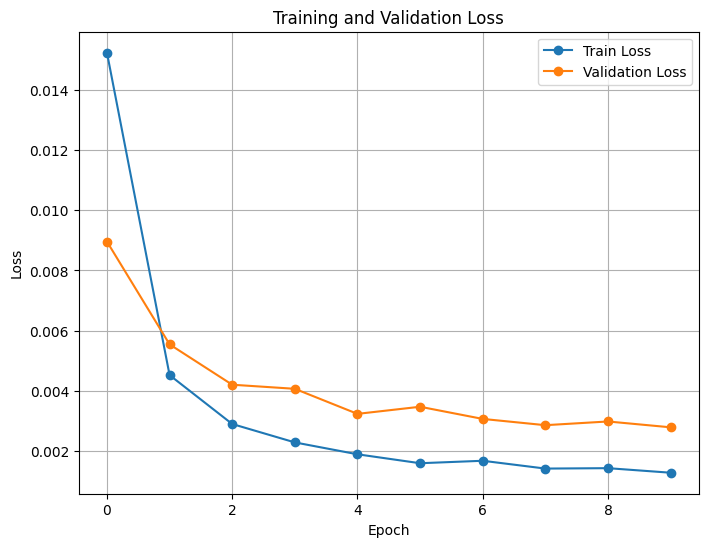

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.plot(train_losses, label='Train Loss', marker='o')
plt.plot(val_losses, label='Validation Loss', marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid(True)
plt.show()


# Final Report

## Pipeline Overview
- **Data Loading:** RGB images, bounding box parameters (7D), point clouds, and masks are loaded.
- **Preprocessing:** Images are resized to 224x224; point clouds (if in image format) are reshaped to [N, 3].
- **Model:** A dual-branch network (ResNet18 for RGB and an MLP for point clouds) is used to regress a 7D bounding box.
- **Training:** The model was trained using Smooth L1 loss, with training and validation loss curves as shown.
- **Evaluation:**
  - **Average Test IoU (axis-aligned, ignoring heading):** 0.0635
  - **Mean Center L1 Error:** [Value]
  - **Mean Size L1 Error:** [Value]
- **Visualizations:**
  - 2D projections of bounding boxes on the RGB image.
  - 3D visualizations of predicted and ground truth boxes with point cloud samples.

## Limitations & Future Work
- Current IoU computation ignores heading; implementing an oriented 3D IoU is a potential improvement.
- Additional metrics (e.g., mAP) and more advanced 3D architectures (e.g., PointNet++, VoteNet) could further improve performance.
- Further hyperparameter tuning and longer training may yield better results.

